## Importing necessary libraries

In [29]:
import numpy as np
import pandas as pd

from cadv_exploration.data_models import Constraints, ValidationResults
from cadv_exploration.loader import FileLoader
from cadv_exploration.utils._utils import get_project_root

## initializing the project root and the path to the data

In [30]:
project_root = get_project_root()
processed_data_path = project_root / 'data_processed' / 'playground-series-s4e10' / '2'
train_file_path = processed_data_path / "files_with_clean_test_data" / "train.csv"
constraints_path = processed_data_path / 'constraints'
deequ_constraints = Constraints.from_yaml(input_path=constraints_path / 'deequ_constraints.yaml')
cadv_constraints_dict = {}
for cadv_script_constraints_path in constraints_path.iterdir():
    if cadv_script_constraints_path.is_dir():
        cadv_constraints = Constraints.from_yaml(input_path=cadv_script_constraints_path / 'cadv_constraints.yaml')
        cadv_constraints_dict[cadv_script_constraints_path.name] = cadv_constraints

In [31]:
train_data = FileLoader.load_csv(train_file_path)
all_column_names = list(train_data.columns)

## Plotting the distribution of the constraints

In [32]:
def get_suggestion_frequency(constraints: Constraints, all_column_names: list):
    suggestion_frequency = {column_name: (0, 0) for column_name in all_column_names}
    for column_name in constraints.constraints.keys():
        valid_suggestion_frequency = sum([c.validity == "Valid" for c in constraints.constraints[column_name].code])
        invalid_suggestion_frequency = sum([c.validity == "Invalid" for c in constraints.constraints[column_name].code])
        suggestion_frequency[column_name] = (valid_suggestion_frequency, invalid_suggestion_frequency)
    return suggestion_frequency

In [33]:
deequ_suggestion_frequency = get_suggestion_frequency(deequ_constraints, all_column_names)
cadv_suggestion_frequency_dict = {}
for script_name, cadv_constraints in cadv_constraints_dict.items():
    cadv_suggestion_frequency_dict[script_name] = get_suggestion_frequency(cadv_constraints, all_column_names)

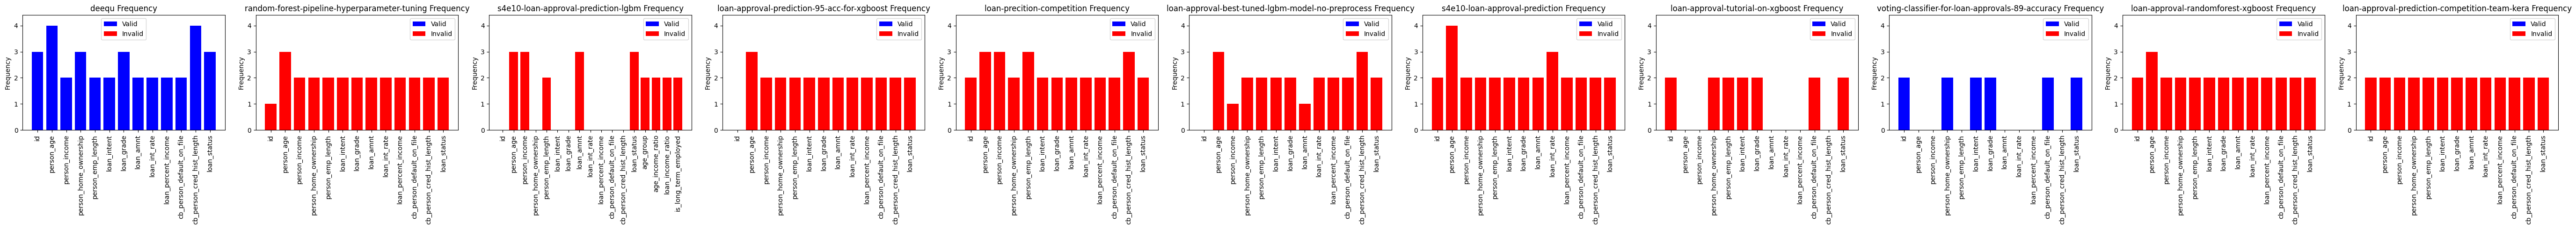

In [34]:
import matplotlib.pyplot as plt


def plot_suggestion_frequency(ax, suggestion_frequency: dict, ylim=None):
    """
    Plot a single suggestion frequency stacked bar chart.
    """
    # Separate valid and invalid frequencies
    column_names = list(suggestion_frequency.keys())
    valid_frequencies = [freq[0] for freq in suggestion_frequency.values()]
    invalid_frequencies = [freq[1] for freq in suggestion_frequency.values()]

    # Bar positions
    x = range(len(column_names))

    # Plot stacked bars
    ax.bar(x, valid_frequencies, label='Valid', color='blue')
    ax.bar(x, invalid_frequencies, bottom=valid_frequencies, label='Invalid', color='red')

    ylim = max(valid_frequencies + invalid_frequencies) * 1.1 if ylim is None else ylim

    # Customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(column_names, rotation=90)
    ax.set_ylabel('Frequency')
    ax.set_ylim(0, ylim)
    ax.set_title('Suggestion Frequency')
    ax.legend()


def plot_suggestion_frequencies(**suggestion_frequency_dict):
    """
    Plot multiple suggestion frequency charts in subplots.
    """
    num_plots = len(suggestion_frequency_dict)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))  # 1 row, num_plots columns

    # Ensure axes is iterable even for a single plot
    if num_plots == 1:
        axes = [axes]

    ylim = max([max([freq[0] + freq[1] for freq in suggestion_frequency.values()]) for suggestion_frequency in
                suggestion_frequency_dict.values()]) * 1.1

    # Loop through data and axes
    for ax, (script_name, suggestion_frequency) in zip(axes, suggestion_frequency_dict.items()):
        plot_suggestion_frequency(ax, suggestion_frequency, ylim)
        ax.set_title(f'{script_name} Frequency')

    # Adjust layout
    plt.tight_layout()
    plt.show()


plot_suggestion_frequencies(deequ=deequ_suggestion_frequency, **cadv_suggestion_frequency_dict)

## Plotting the validation results

In [35]:
project_root = get_project_root()
processed_data_path = project_root / 'data_processed' / 'playground-series-s4e10' / '2'
train_file_path = processed_data_path / "files_with_clean_test_data" / "train.csv"
output_path = processed_data_path / 'output'
validation_results_on_clean_test_data_deequ = ValidationResults.from_yaml(
    input_path=output_path / 'validation_results_on_clean_test_data_deequ.yaml')
validation_results_on_corrupted_test_data_deequ = ValidationResults.from_yaml(
    input_path=output_path / 'validation_results_on_corrupted_test_data_deequ.yaml')
cadv_validation_results_dict = {}
for script_path in output_path.iterdir():
    if not script_path.is_dir():
        continue
    script_name = script_path.name
    validation_results_on_clean_test_data_cadv = ValidationResults.from_yaml(
        input_path=output_path / f"{script_name}" / "validation_results_on_clean_test_data_cadv.yaml")
    validation_results_on_corrupted_test_data_cadv = ValidationResults.from_yaml(
        input_path=output_path / f"{script_name}" / "validation_results_on_corrupted_test_data_cadv.yaml")
    cadv_validation_results_dict[script_name] = (validation_results_on_clean_test_data_cadv,
                                                 validation_results_on_corrupted_test_data_cadv)

In [36]:
train_data = FileLoader.load_csv(train_file_path)
all_column_names = list(train_data.columns)

In [37]:
def calculate_validation_reults(validation_results: ValidationResults, all_column_names: list):
    suggestion_frequency = {column_name: (0, 0) for column_name in all_column_names}
    for column_name in validation_results.results.keys():
        passed_suggestion_frequency = sum([c.status == "Passed" for c in validation_results.results[column_name].code])
        Failed_suggestion_frequency = sum([c.status == "Failed" for c in validation_results.results[column_name].code])
        suggestion_frequency[column_name] = (passed_suggestion_frequency, Failed_suggestion_frequency)
    return suggestion_frequency

In [38]:
deequ_validation_results_on_clean_test_data = calculate_validation_reults(validation_results_on_clean_test_data_deequ,
                                                                          all_column_names)
deequ_validation_results_on_corrupted_test_data = calculate_validation_reults(
    validation_results_on_corrupted_test_data_deequ,
    all_column_names)
cadv_validation_results_on_clean_test_data_dict = {}
cadv_validation_results_on_corrupted_test_data_dict = {}
for script_name, (validation_results_on_clean_test_data_cadv,
                  validation_results_on_corrupted_test_data_cadv) in cadv_validation_results_dict.items():
    cadv_validation_results_on_clean_test_data_dict[script_name] = calculate_validation_reults(
        validation_results_on_clean_test_data_cadv, all_column_names)
    cadv_validation_results_on_corrupted_test_data_dict[script_name] = calculate_validation_reults(
        validation_results_on_corrupted_test_data_cadv, all_column_names)

In [39]:



def plot_validation_result(ax, validation_results: dict, ylim=None):
    """
    Plot a single validation results stacked bar chart.
    """
    # Separate passed and failed frequencies
    column_names = list(validation_results.keys())
    passed_frequencies = [freq[0] for freq in validation_results.values()]
    failed_frequencies = [freq[1] for freq in validation_results.values()]

    # Bar positions
    x = range(len(column_names))

    # Plot stacked bars
    ax.bar(x, passed_frequencies, label='Passed', color='blue')
    ax.bar(x, failed_frequencies, bottom=passed_frequencies, label='Failed', color='red')

    ylim = max(passed_frequencies + failed_frequencies) * 1.1 if ylim is None else ylim

    # Customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(column_names, rotation=90)
    ax.set_ylabel('Frequency')
    ax.set_ylim(0, ylim)
    ax.set_title('Validation Results')
    ax.legend()


def plot_validation_results(**validation_results_dict):
    """
    Plot multiple validation results charts in subplots.
    """
    num_plots = len(validation_results_dict)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))  # 1 row, num_plots columns

    # Ensure axes is iterable even for a single plot
    if num_plots == 1:
        axes = [axes]

    ylim = max([max([freq[0] + freq[1] for freq in validation_results.values()]) for validation_results in
                validation_results_dict.values()]) * 1.1

    # Loop through data and axes
    for ax, (script_name, validation_results) in zip(axes, validation_results_dict.items()):
        plot_validation_result(ax, validation_results, ylim)
        ax.set_title(f'{script_name} Validation Results')

    # Adjust layout
    plt.tight_layout()
    plt.show()

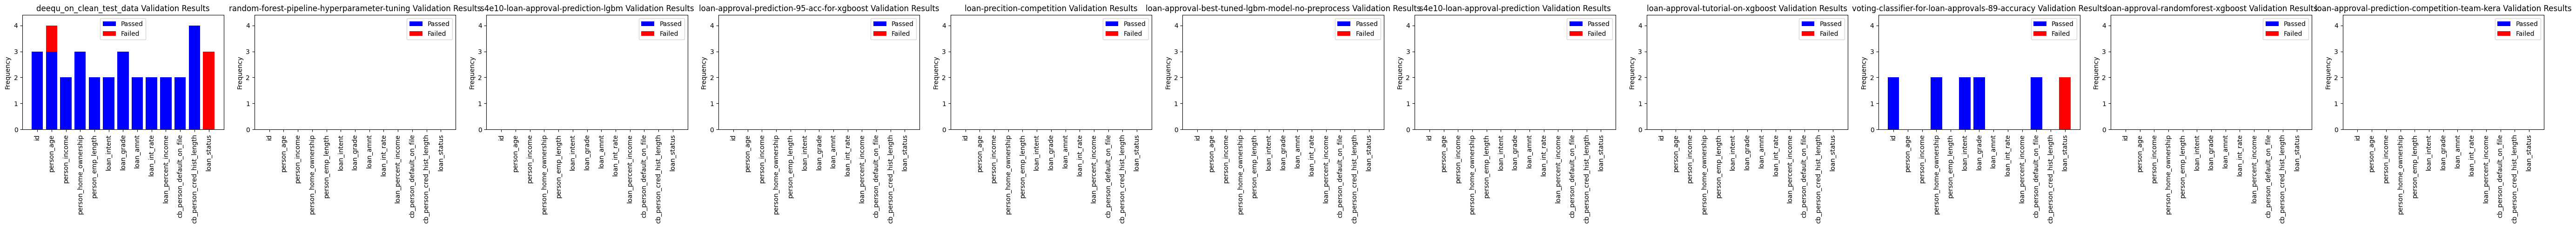

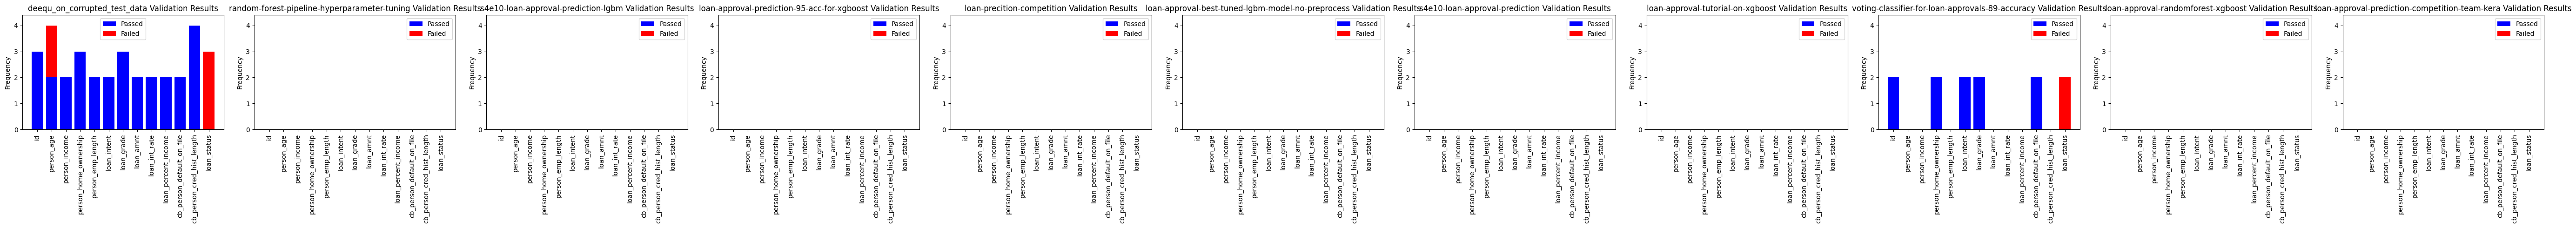

In [40]:
plot_validation_results(deequ_on_clean_test_data=deequ_validation_results_on_clean_test_data,
                        **cadv_validation_results_on_clean_test_data_dict)
plot_validation_results(deequ_on_corrupted_test_data=deequ_validation_results_on_corrupted_test_data,
                        **cadv_validation_results_on_corrupted_test_data_dict)

## Plotting the performance drops of the models in the scripts

In [41]:
project_root = get_project_root()
processed_data_path = project_root / 'data_processed' / 'playground-series-s4e10' / '2'
train_file_path = processed_data_path / "files_with_clean_test_data" / "train.csv"
output_path = processed_data_path / 'output'

model_performance_drops_dict = {}
for script_path in output_path.iterdir():
    script_name = script_path.name
    if not script_path.is_dir():
        continue
    model_performance = FileLoader.load_csv(output_path / script_name / 'model_performance.csv')
    model_performance_drops_dict[script_name] = model_performance

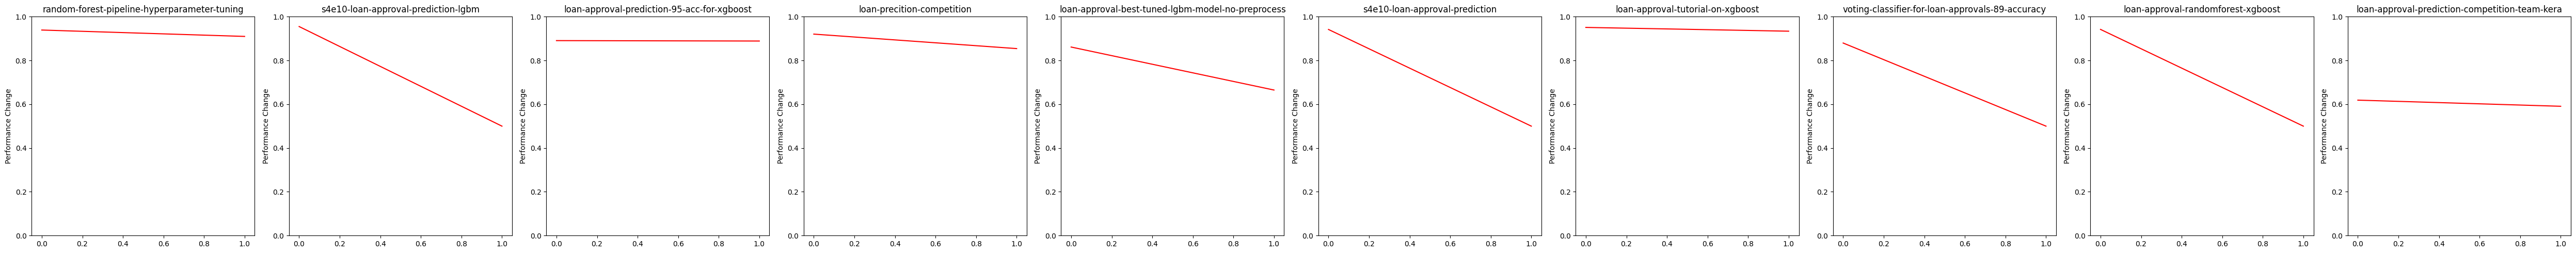

In [42]:
import matplotlib.pyplot as plt


def plot_model_performance_changes(ax, model_performance_drops: pd.DataFrame):
    model_performance_drops.iloc[0, 1] = 0.5 if np.isnan(model_performance_drops.iloc[0, 1]) else \
        model_performance_drops.iloc[0, 1]
    color = 'blue' if model_performance_drops.iloc[0, 0] <= model_performance_drops.iloc[0, 1] else 'red'
    ax.plot(model_performance_drops.iloc[0, :].to_list(), color=color)
    # Customize plot
    ax.set_ylabel('Performance Change')
    ax.set_title('Model Performance Changes')
    ax.set_ylim(0, 1)


def plot_model_performance_changes_all(**model_performance_drops_dict):
    """
    Plot multiple model performance drops charts in subplots.
    """
    num_plots = len(model_performance_drops_dict)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))  # 1 row, num_plots columns

    # Ensure axes is iterable even for a single plot
    if num_plots == 1:
        axes = [axes]

    # Loop through data and axes
    for ax, (script_name, model_performance_drops) in zip(axes, model_performance_drops_dict.items()):
        plot_model_performance_changes(ax, model_performance_drops)
        ax.set_title(f'{script_name}')

    # Adjust layout
    plt.tight_layout()
    plt.show()


plot_model_performance_changes_all(**model_performance_drops_dict)